# Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from keras.preprocessing import image_dataset_from_directory, image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Rescaling, RandomRotation, RandomZoom, RandomFlip, RandomContrast
from keras.regularizers import l2
from keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall, AUC
from keras.callbacks import EarlyStopping
from keras.applications import InceptionResNetV2, EfficientNetB7

# Load Data

In [ ]:
dataset_path = '../teeth_dataset/Teeth_Dataset'

In [5]:
dataset_dir = os.listdir(dataset_path)
print(f'The Dataset directory constists of {dataset_dir} directories.')

The Dataset directory constists of ['Testing', 'Validation', 'Training'] directories.


In [6]:
train_path = dataset_path + '/Training'
val_path = dataset_path + '/Validation'
test_path = dataset_path + '/Testing'

In [7]:
train_dataset = image_dataset_from_directory(
    directory = train_path,
    labels = "inferred",
    label_mode = "categorical",
    image_size = (224, 224),
)

Found 3087 files belonging to 7 classes.


In [8]:
val_dataset = image_dataset_from_directory(
    directory = val_path,
    labels = "inferred",
    label_mode = "categorical",
    image_size = (224, 224),
)

Found 1028 files belonging to 7 classes.


In [9]:
test_dataset = image_dataset_from_directory(
    directory = test_path,
    labels = "inferred",
    label_mode = "categorical",
    image_size = (224, 224),
)

Found 1028 files belonging to 7 classes.


In [10]:
diseases = os.listdir(train_path)
print(f'Labels represent the following teeth diseases: {diseases}.')

Labels represent the following teeth diseases: ['CoS', 'MC', 'OT', 'OLP', 'OC', 'Gum', 'CaS'].


In [11]:
for images, labels in train_dataset.take(1):
    print("Input shape:", images.shape)

Input shape: (32, 224, 224, 3)


# Visualization functions

- __This include 4 fuctions:__
1. __Prediction():__ Take a single image and predict its label
2. __Loss_Acc_Evol():__ Plot the model’s training history (loss and accuracy over epochs)
3. __plot_conf_matrix():__ Display the confusion matrix for the test dataset
4. __plot_act_vs_pred():__ Show 25 images with their actual vs predicted labels

In [12]:
def prediction(testing_image_path, actual_label, model, class_map, image_size=(224, 224)):
    img = image.load_img(testing_image_path, target_size=image_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_input = np.expand_dims(img_array, axis=0)  # Shape -> (1, height, width, 3)

    predicted_label = class_map[np.argmax(model.predict(img_input))]

    plt.figure(figsize=(4, 4))
    plt.imshow(img_array)
    plt.title(f'Actual: {actual_label} \nPredicted: {predicted_label}')
    plt.axis('off')
    plt.grid(False)
    plt.show()

In [13]:
def Loss_Acc_Evol(history):
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='b')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='m')
    plt.legend()
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='b')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='m')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.show()

In [14]:
def plot_conf_matrix(model):
    # Extract true labels and predictions from the test_dataset
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        preds = model.predict(images)

        y_true.extend(tf.argmax(labels, axis=1).numpy())
        y_pred.extend(tf.argmax(preds, axis=1).numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute the confusion matrix
    cm = tf.math.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=diseases, yticklabels=diseases)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_act_vs_pred(model):
    for images, labels in test_dataset.take(1):
        predictions = model.predict(images)
        y_pred_classes = tf.argmax(predictions, axis=1).numpy()
        y_true_classes = tf.argmax(labels, axis=1).numpy()
        break

    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(25):
        image = (images[i].numpy() * 255).astype("uint8")
        true = diseases[y_true_classes[i]]
        pred = diseases[y_pred_classes[i]]
        color = 'green' if true == pred else 'red'

        axes[i].imshow(image)
        axes[i].set_title(f"True: {true}\nPred: {pred}", color=color, fontsize=9)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Preprocessing

In [16]:
data_generator = tf.keras.Sequential([
    RandomRotation(0.15),
    RandomZoom(0.2),
    RandomFlip("horizontal"),
    RandomContrast(0.2)
])

In [17]:
def augment(images, labels):
    return data_generator(images, training=True), labels

In [18]:
def preprocess(data, shuffle_size=0, data_type=None):
    data = data.map(lambda x, y: (Rescaling(1./255)(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if data_type == 'train' and shuffle_size > 0:
        data = data.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        data = data.shuffle(shuffle_size)
    data = data.cache()
    data = data.prefetch(tf.data.AUTOTUNE)
    return data

In [19]:
train_dataset = preprocess(train_dataset, shuffle_size=1000, data_type='train')
val_dataset = preprocess(val_dataset)
test_dataset = preprocess(test_dataset)

- Use weights to balance the class distribution during training.

In [20]:
label_list = []
for _, labels in train_dataset.unbatch():
    label_list.append(np.argmax(labels.numpy()))
label_list = np.array(label_list)

class_weights = compute_class_weight('balanced', classes=np.unique(label_list), y=label_list)
class_weights = dict(enumerate(class_weights))

# Model Architecture

In [21]:
def Model(base_model):
    model = Sequential([
        base_model,

        Flatten(),

        Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),

        Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),

        Dense(128, activation='relu'),
        BatchNormalization(),

        Dense(64, activation='relu'),
        Dropout(0.4),

        Dense(len(diseases), activation='softmax')
    ])

    model.compile(optimizer=Adamax(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           Precision(name='precision'),
                           Recall(name='recall'),
                           AUC(name='auc')])

    return model

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# PreTrained Models

## 1. EfficientNetB7

In [24]:
base_model_1 = EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

base_model_1.trainable = True
for layer in base_model_1.layers[:250]:
    layer.trainable = False

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [25]:
EfficientNet_Model = Model(base_model_1)

In [26]:
EfficientNet_Model_history = EfficientNet_Model.fit(train_dataset,epochs = 100,validation_data = val_dataset,callbacks=[early_stop], class_weight=class_weights, verbose=1)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.1614 - auc: 0.5147 - loss: 2.5537 - precision: 0.1390 - recall: 0.0350 - val_accuracy: 0.1488 - val_auc: 0.5082 - val_loss: 2.2176 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 121s 718ms/step - accuracy: 0.1941 - auc: 0.5761 - loss: 2.1723 - precision: 0.2972 - recall: 0.0373 - val_accuracy: 0.1488 - val_auc: 0.5366 - val_loss: 2.0686 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 720ms/step - accuracy: 0.2486 - auc: 0.6299 - loss: 2.0219 - precision: 0.4705 - recall: 0.0542 - val_accuracy: 0.2208 - val_auc: 0.5906 - val_loss: 1.9979 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 710ms/step - accuracy: 0.3090 - auc: 0.6777 - loss: 1.8844 - precision: 0.5874 - recall: 0.0878 - val_accuracy: 0.2403 - val_auc: 0.6242 - val_loss: 2.1016 - val_precision: 0.3527 - val_recall: 0.1420
E

In [27]:
EfficientNet_Model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 7, 7, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 125440)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    32,112,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,515,518 (1.07 GB)

 Trainable params: 95,097,487 (362.77 MB)

 Non-trainable params: 1,223,055 (4.67 MB)

 Optimizer params: 190,194,976 (725.54 MB)

In [28]:
train_loss_1, train_acc_1, train_prec_1, train_rec_1, train_auc_1 = EfficientNet_Model.evaluate(train_dataset)
val_loss_1, val_acc_1, val_prec_1, val_rec_1, val_auc_1 = EfficientNet_Model.evaluate(val_dataset)
test_loss_1, test_acc_1, test_prec_1, test_rec_1, test_auc_1 = EfficientNet_Model.evaluate(test_dataset)

97/97 ━━━━━━━━━━━━━━━━━━━━ 34s 350ms/step - accuracy: 0.9987 - auc: 1.0000 - loss: 0.1005 - precision: 0.9989 - recall: 0.9987
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.9323 - auc: 0.9901 - loss: 0.3573 - precision: 0.9337 - recall: 0.9281
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.9236 - auc: 0.9883 - loss: 0.3681 - precision: 0.9303 - recall: 0.9205


In [29]:
print('== Training ==\n' +\
      f'Accuracy: {train_acc_1:.4f}, Precision: {train_prec_1:.4f}, Recall: {train_rec_1:.4f}, AUC: {train_auc_1:.4f}\n\n' +\
      '== Validation ==\n' +\
      f'Accuracy: {val_acc_1:.4f}, Precision: {val_prec_1:.4f}, Recall: {val_rec_1:.4f}, AUC: {val_auc_1:.4f}\n\n' +\
      '== Testing ==\n' +\
      f'Accuracy: {test_acc_1:.4f}, Precision: {test_prec_1:.4f}, Recall: {test_rec_1:.4f}, AUC: {test_auc_1:.4f}'
     )

== Training ==
Accuracy: 0.9981, Precision: 0.9984, Recall: 0.9981, AUC: 1.0000

== Validation ==
Accuracy: 0.9319, Precision: 0.9362, Recall: 0.9280, AUC: 0.9892

== Testing ==
Accuracy: 0.9358, Precision: 0.9393, Recall: 0.9329, AUC: 0.9909


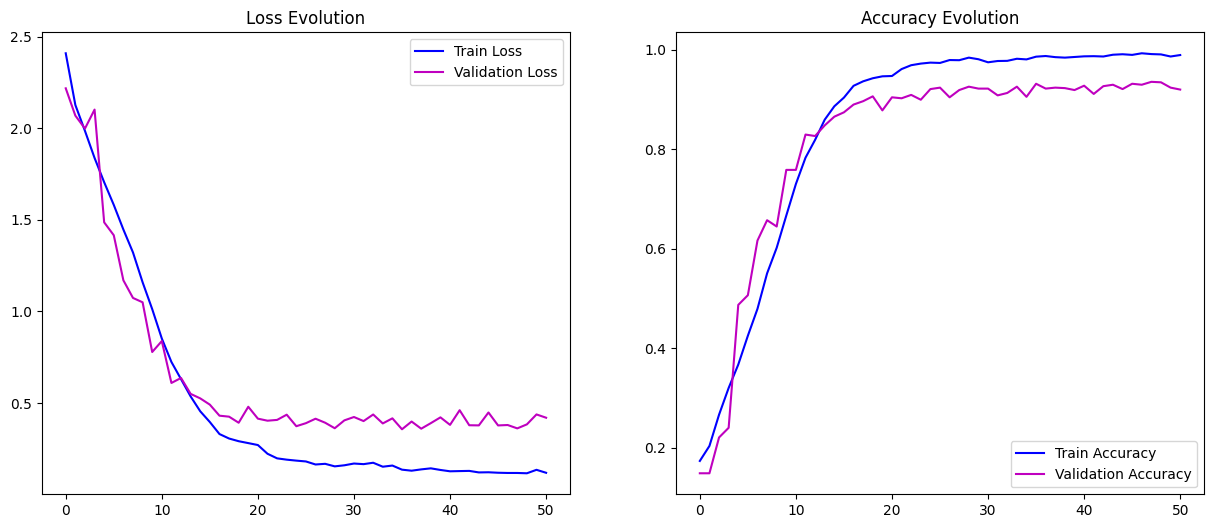

In [30]:
Loss_Acc_Evol(EfficientNet_Model_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

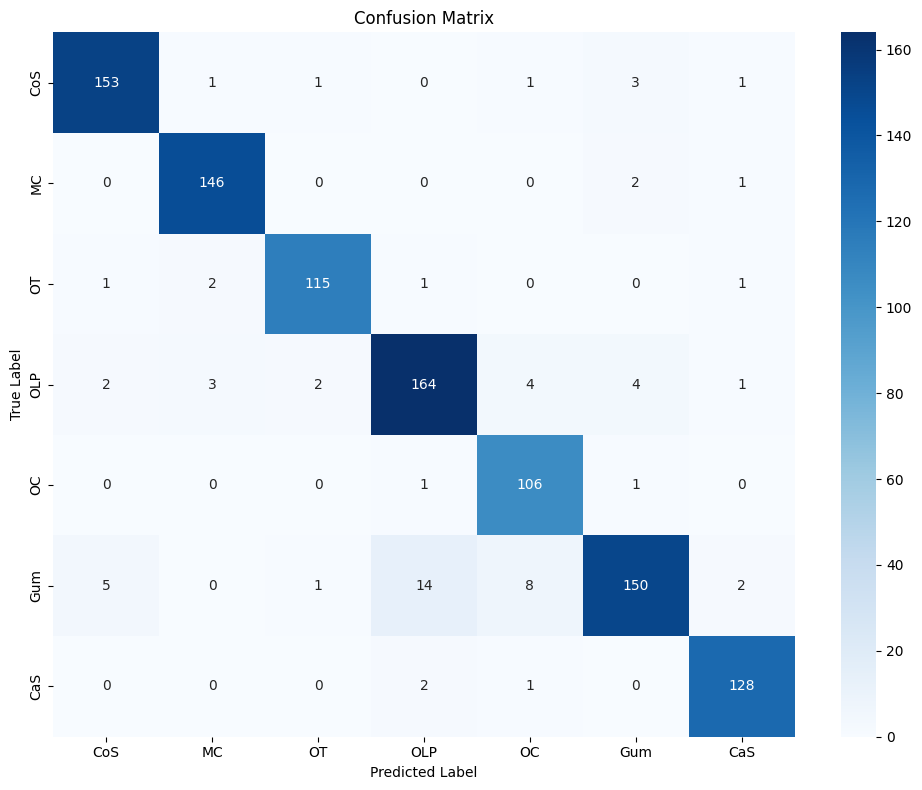

In [31]:
plot_conf_matrix(EfficientNet_Model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


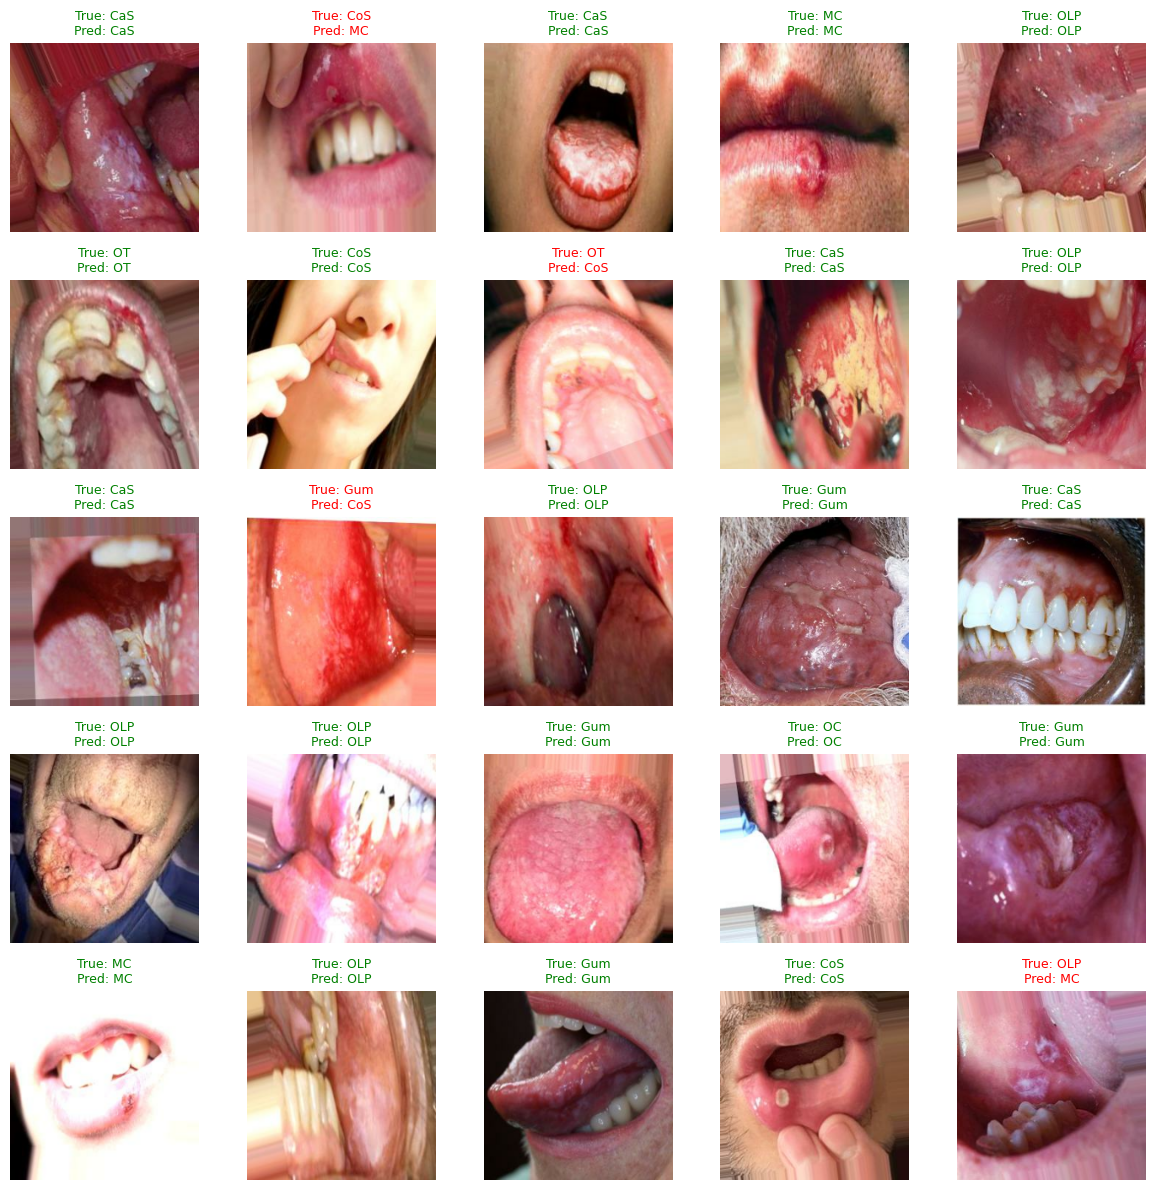

In [32]:
plot_act_vs_pred(EfficientNet_Model)

## 2. InceptionResNetV2

In [23]:
base_model_2 = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape = (224, 224, 3)
)

base_model_2.trainable = True
for layer in base_model_2.layers[:100]:
    layer.trainable = False

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [24]:
ResNet_Model = Model(base_model_2)

In [25]:
ResNet_Model_history = ResNet_Model.fit(train_dataset,epochs = 100,validation_data = val_dataset,callbacks=[early_stop], class_weight=class_weights, verbose=1)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.2330 - auc: 0.6029 - loss: 2.2823 - precision: 0.2801 - recall: 0.0929 - val_accuracy: 0.3706 - val_auc: 0.7518 - val_loss: 1.8430 - val_precision: 0.4526 - val_recall: 0.2461
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 72s 470ms/step - accuracy: 0.5178 - auc: 0.8429 - loss: 1.4074 - precision: 0.6989 - recall: 0.3509 - val_accuracy: 0.6702 - val_auc: 0.9331 - val_loss: 0.9854 - val_precision: 0.8204 - val_recall: 0.5243
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 472ms/step - accuracy: 0.7450 - auc: 0.9538 - loss: 0.8069 - precision: 0.8516 - recall: 0.6262 - val_accuracy: 0.8093 - val_auc: 0.9735 - val_loss: 0.6563 - val_precision: 0.9031 - val_recall: 0.7257
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 475ms/step - accuracy: 0.8995 - auc: 0.9914 - loss: 0.4358 - precision: 0.9570 - recall: 0.8277 - val_accuracy: 0.8765 - val_auc: 0.9869 - val_loss: 0.4635 - val_precision: 0.9092 - val_recall: 0.8278
Epoch 5/100
97/97 ━━━━━━━━

In [34]:
ResNet_Model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,830,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_203         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_204         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_205         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,173,271 (729.27 MB)

 Trainable params: 63,447,959 (242.03 MB)

 Non-trainable params: 829,392 (3.16 MB)

 Optimizer params: 126,895,920 (484.07 MB)

In [27]:
train_loss_2, train_acc_2, train_prec_2, train_rec_2, train_auc_2 = ResNet_Model.evaluate(train_dataset)
val_loss_2, val_acc_2, val_prec_2, val_rec_2, val_auc_2 = ResNet_Model.evaluate(val_dataset)
test_loss_2, test_acc_2, test_prec_2, test_rec_2, test_auc_2 = ResNet_Model.evaluate(test_dataset)

97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.9980 - auc: 0.9994 - loss: 0.0513 - precision: 0.9981 - recall: 0.9977
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9812 - auc: 0.9961 - loss: 0.1249 - precision: 0.9815 - recall: 0.9810
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.9795 - auc: 0.9957 - loss: 0.1449 - precision: 0.9795 - recall: 0.9795


In [28]:
print('== Training ==\n' +\
      f'Accuracy: {train_acc_2:.4f}, Precision: {train_prec_2:.4f}, Recall: {train_rec_2:.4f}, AUC: {train_auc_2:.4f}\n\n' +\
      '== Validation ==\n' +\
      f'Accuracy: {val_acc_2:.4f}, Precision: {val_prec_2:.4f}, Recall: {val_rec_2:.4f}, AUC: {val_auc_2:.4f}\n\n' +\
      '== Testing ==\n' +\
      f'Accuracy: {test_acc_2:.4f}, Precision: {test_prec_2:.4f}, Recall: {test_rec_2:.4f}, AUC: {test_auc_2:.4f}'
     )

== Training ==
Accuracy: 0.9977, Precision: 0.9981, Recall: 0.9974, AUC: 0.9993

== Validation ==
Accuracy: 0.9825, Precision: 0.9834, Recall: 0.9815, AUC: 0.9956

== Testing ==
Accuracy: 0.9815, Precision: 0.9815, Recall: 0.9815, AUC: 0.9960


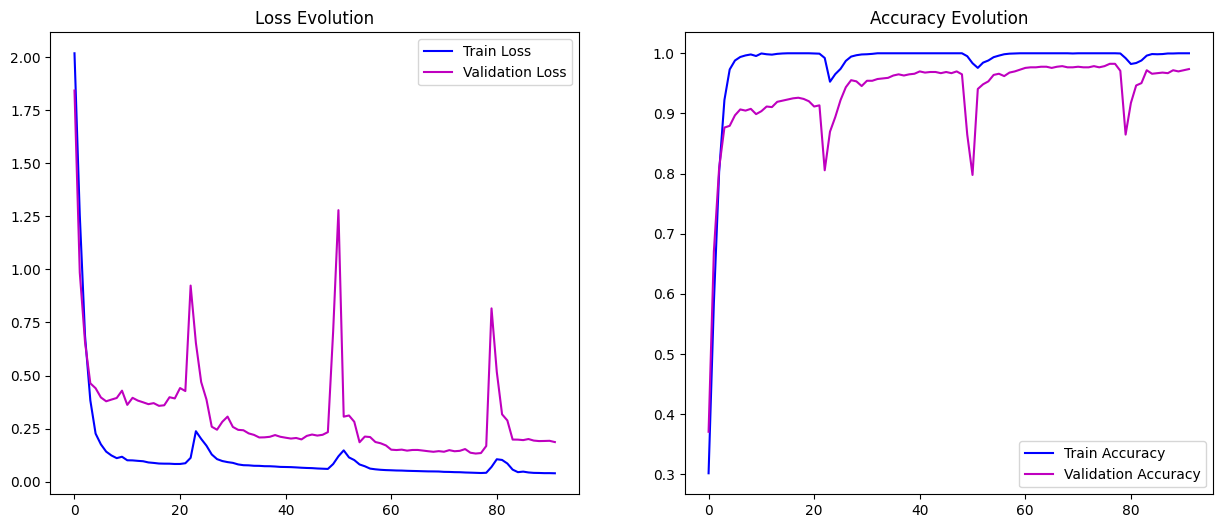

In [29]:
Loss_Acc_Evol(ResNet_Model_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

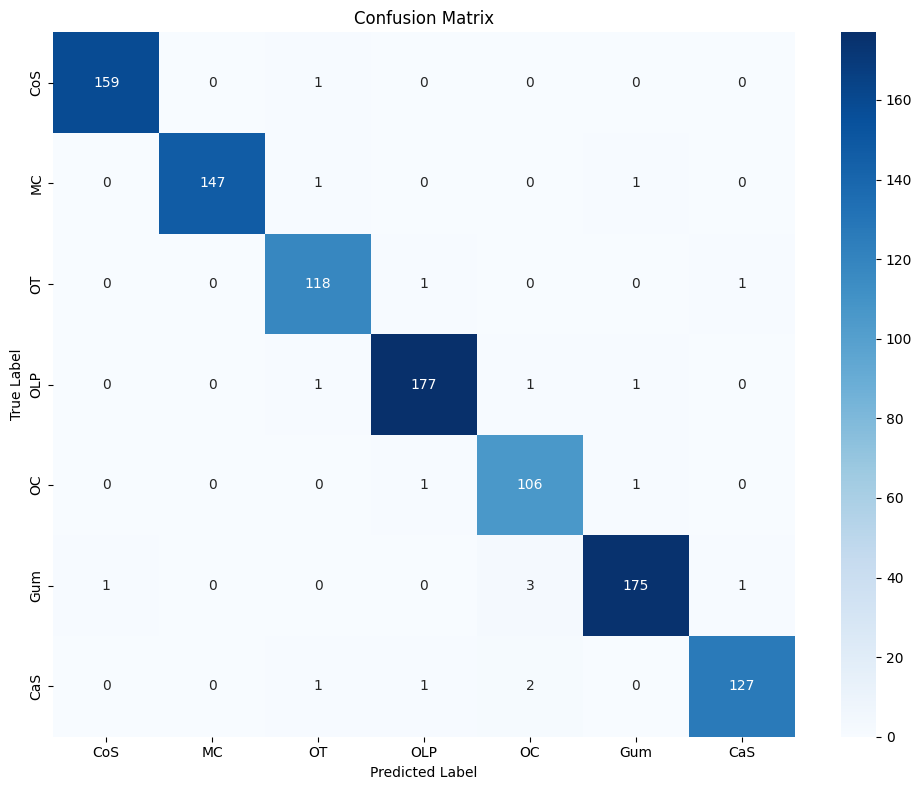

In [30]:
plot_conf_matrix(ResNet_Model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


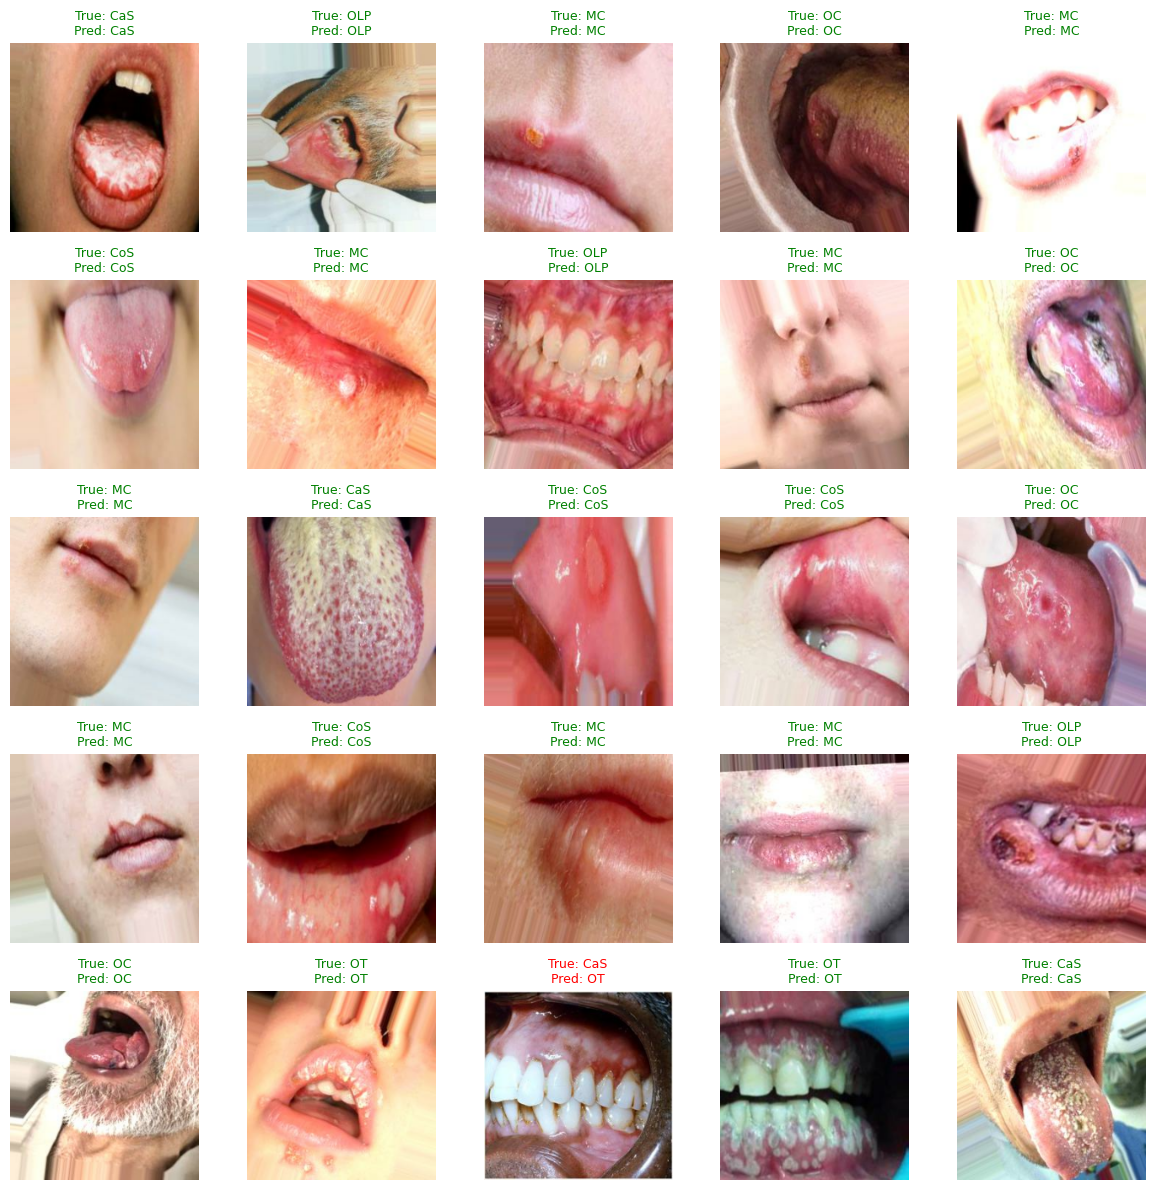

In [31]:
plot_act_vs_pred(ResNet_Model)

# Save Best Model

In [ ]:
ResNet_Model.save('Modified_InceptionResNetV2_Model_Teeth_disease_classification.keras')

### Conclusion
- Based on the performance of the two previously evaluated models, We conclude that the Modified InceptionResNetV2 Model achieves stong results with relatively high accuracy while effectively minimizing overfitting.